# EfficientDet (with EfficientNetv2 as backbone)

#import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import skimage
import skimage.io as io
import copy
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv
from numpy.random import shuffle
from torchvision import tv_tensors

import os
import torch
import cv2

from torch.utils.data import Dataset
from torch.utils.data import random_split
#
import torchvision

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# Prepare data function

In [ ]:
#train_data_path = dataset_path/'training_images'

class PrepareData:
    def __init__(self):  #, image_path
      #self.image_path = image_path
      self.train_split = 0.8  # Ratio of the training data split
      self.test_split = 0.1  # Ratio of the test data split
      self.val_split = 0.1  # Ratio of the validation data split

    def __call__(self, filename):

      with open(filename, "r") as json_file:
        # Load and parse the JSON data
        data = json.load(json_file)

      print(data[0])

      # Compute the lengths of each split
      total_length = len(data)
      train_length = int(total_length * self.train_split)+1
      test_length = int(total_length * self.val_split)#+1
      val_length = int(total_length * self.test_split)#+1

      print(total_length, train_length, test_length, val_length)

      # Perform the random split for train, test e validation set
      train_data, val_data, test_data = torch.utils.data.random_split(data, [train_length, val_length, test_length])

      #print(train_data[0])
      # For each image take also the segmentation
      train_set = []
      for data in train_data:
        train_set.append(data)

      val_set = []
      for data in val_data:
        val_set.append(data)

      test_set = []
      for data in test_data:
        test_set.append(data)

      return train_set, val_set, test_set

In [ ]:
from pathlib import Path

dataset_path = Path('/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/TACO_MJU_Images/')
#list(dataset_path.iterdir())

In [ ]:
dataset = PrepareData()
train_set, val_set, test_set = dataset('/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/only_taco.json')

{'id': 2467, 'filename': 'batch_1-000006.png', 'width': 640, 'height': 480, 'seg': [[233.597918022121, 290.0146412884334, 236.51268705270007, 281.34699853587114, 236.09629147690305, 275.2562225475842, 228.60117111255693, 264.0117130307467, 224.02081977878984, 255.10980966325036, 216.10930383864672, 244.33382137628112, 215.2765126870527, 235.43191800878478, 217.77488614183474, 225.8272327964861, 220.27325959661678, 221.37628111273793, 216.52569941444372, 209.89751098096633, 218.60767729342876, 201.93265007320645, 223.18802862719585, 192.32796486090777, 230.68314899154197, 180.1464128843338, 240.26024723487313, 170.30746705710104, 247.75536759921926, 158.82869692532944, 248.17176317501625, 137.0424597364568, 244.84059856864022, 81.05417276720351, 241.92582953806115, 76.83748169838945, 236.92908262849707, 71.68374816983895, 237.34547820429407, 64.65592972181553, 239.8438516590761, 52.47437774524158, 233.181522446324, 48.02342606149341, 234.84710474951203, 39.82430453879942, 240.6766428106

# Dataset Adaptor (no for inference)

In [ ]:
from pathlib import Path
import PIL
from torchvision.transforms.functional import resize
import numpy as np

class DatasetAdaptor:
    def __init__(self, data):
        self.data = data
        self.transform = transforms.ToTensor()

    def __len__(self) -> int:
        return len(self.data)

    def masks_to_boxes(self, masks):
        boxes = []
        for mask in masks:
            non_zero_coords = torch.nonzero(mask)
            #print(non_zero_coords)
            if non_zero_coords.size(0) > 0:
                min_coords = torch.min(non_zero_coords, dim=0).values
                max_coords = torch.max(non_zero_coords, dim=0).values
                #print('PRIMA', min_coords, max_coords)
                min_coords = torch.flip(min_coords, dims=[0])
                max_coords = torch.flip(max_coords, dims=[0])
                #print('DOPO', min_coords, max_coords)
                if min_coords[0]<max_coords[0] and min_coords[1]<max_coords[1]:
                  box = torch.cat([min_coords, max_coords], dim=0)
                  boxes.append(box)
                else:
                  #print(mask)
                  print(min_coords, max_coords)
                  boxes.append(torch.tensor([100, 200, 150, 250]))
            else:
                # If there are no non-zero coordinates, add an empty box
                boxes.append(torch.zeros(4))

        # Stack the list of boxes into a tensor
        boxes = torch.stack(boxes)

        return boxes


    def get_image_and_labels_by_idx(self, idx):
        sample = self.data[idx]

        img_name = sample['filename']
        img_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/TACO_MJU_Images/'+img_name
        png_image = PIL.Image.open(img_path)
        # Resize the image in place
        resize(png_image, (512, 512))
        #png_image = read_image(img_path)
        #tensor_img = tv_tensors.Image(png_image)

        #immagini della mask
        for mask in os.listdir('/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/masks_unique/new'):
          if img_name[:-4] in mask:
            #print(mask)
            mask_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/masks_unique/new/'+mask
            mask_image = read_image(mask_path)
            resize(mask_image, (512, 512))
            #print(mask_image.size())
            obj_ids = torch.unique(mask_image)
            # first id is the background, so remove it
            obj_ids = obj_ids[1:]
            num_objs = len(obj_ids)
            masks = []
            for i in obj_ids:
              #print(int(i))
              m = (mask_image.numpy()[0, :, :] == int(i)) #i[:, None, None]) #int(i))
              m = self.transform(m).to(dtype=torch.uint8)
              masks.append(m)

        # get bounding box coordinates for each mask
        tensor_masks = torch.cat(masks, dim=0)

        boxes = self.masks_to_boxes(tensor_masks).numpy()

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64).numpy()

        return png_image, boxes, labels, idx #or array []


    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes.tolist())
        print(class_labels)

the get_image_and_labels_by_idx method returns a tuple containing:

- image: A PIL image
- pascal_bboxes: a numpy array of shape [N, 4] containing the ground truth bounding boxes in Pascal VOC format
- class_labels: a numpy array of shape N containing the ground truth class labels
- image_id : a unique identifier which can be used to identify the image
and the __len__ method.


In [ ]:
#train = DatasetAdaptor(train_set)

def collate(batch):
  return tuple(zip(*batch))

train_data = DatasetAdaptor(train_set)
#train_loader = DataLoader(train_data, batch_size = 4, shuffle=True, collate_fn=collate, pin_memory=False)

val_data = DatasetAdaptor(val_set)
#val_loader = DataLoader(val_data, batch_size = 4, shuffle=False, collate_fn=collate, pin_memory=False)

test_data = DatasetAdaptor(test_set)
#test_loader = DataLoader(test_data, batch_size = 4, shuffle=False, collate_fn=collate, pin_memory=False)

# Define the EfficientDet Dataset

In [ ]:
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
            :, [1, 0, 3, 2]
        ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

In [ ]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

class EfficientDetDataModule(LightningDataModule):

    def __init__(self,
                train_dataset_adaptor,
                validation_dataset_adaptor,
                train_transforms=get_train_transforms(target_img_size=512),
                valid_transforms=get_valid_transforms(target_img_size=512),
                num_workers=4,
                batch_size=8):

        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

    def train_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds, transforms=self.train_tfms
        )

    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return train_loader

    def val_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader

    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

# Creating the model

In [ ]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

In [ ]:
print(f'number of configs: {len(efficientdet_model_param_dict)}')

list(efficientdet_model_param_dict.keys())[::3]

number of configs: 48


['efficientdet_d0',
 'efficientdet_d3',
 'efficientdetv2_dt',
 'cspresdet50',
 'cspdarkdet53',
 'mixdet_l',
 'mobiledetv3_large',
 'efficientdet_q2',
 'efficientdet_em',
 'tf_efficientdet_d1',
 'tf_efficientdet_d4',
 'tf_efficientdet_d7',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite3x']

In [ ]:
def create_model(num_classes=1, image_size=512, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )

    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

# Define the model

In [ ]:
from numbers import Number
from typing import List
from functools import singledispatch
from fastcore.dispatch import typedispatch
from pytorch_lightning import LightningModule
#from lightning.core.decorators import auto_move_data
from ensemble_boxes import ensemble_boxes_wbf


def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels


class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=1,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='tf_efficientnetv2_l',
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms


    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)


    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log("train_loss", losses["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)
        self.log(
            "train_class_loss", losses["class_loss"], on_step=True, on_epoch=True, prog_bar=True,
            logger=True
        )
        self.log("train_box_loss", losses["box_loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)

        return losses['loss']


    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }

        self.log("valid_loss", outputs["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, sync_dist=True)
        self.log(
            "valid_class_loss", logging_losses["class_loss"], on_step=True, on_epoch=True,
            prog_bar=True, logger=True, sync_dist=True
        )
        self.log("valid_box_loss", logging_losses["box_loss"], on_step=True, on_epoch=True,
                 prog_bar=True, logger=True, sync_dist=True)

        return {'loss': outputs["loss"], 'batch_predictions': batch_predictions}


    @typedispatch
    def predict(self, images: List):
        image_sizes = [(image.size[1], image.size[0]) for image in images]
        images_tensor = torch.stack(
            [
                self.inference_tfms(
                    image=np.array(image, dtype=np.float32),
                    labels=np.ones(1),
                    bboxes=np.array([[0, 0, 1, 1]]),
                )["image"]
                for image in images
            ]
        )

        return self._run_inference(images_tensor, image_sizes)

    @typedispatch
    def predict(self, images_tensor: torch.Tensor):
        if images_tensor.ndim == 3:
            images_tensor = images_tensor.unsqueeze(0)
            images_tensor = F.resize(images_tensor, (512, 512))
            print(images_tensor.shape)
        if (
            images_tensor.shape[-1] != self.img_size
            or images_tensor.shape[-2] != self.img_size
        ):
            raise ValueError(
                f"Input tensors must be of shape (N, 3, {self.img_size}, {self.img_size})"
            )

        num_images = images_tensor.shape[0]
        image_sizes = [(self.img_size, self.img_size)] * num_images

        return self._run_inference(images_tensor.float(), image_sizes)

    def _run_inference(self, images_tensor, image_sizes):
        dummy_targets = self._create_dummy_inference_targets(
            num_images=images_tensor.shape[0]
        )

        detections = self.model(images_tensor.to(self.device), dummy_targets)[
            "detections"
        ]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.__rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences

    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.img_size, self.img_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets

    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
            predictions, image_size=self.img_size, iou_thr=self.wbf_iou_threshold
        )

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(scores > self.prediction_confidence_threshold)[0]
        boxes = boxes[indexes]

        return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

    def __rescale_bboxes(self, predicted_bboxes, image_sizes):
        scaled_bboxes = []
        for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = img_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.img_size,
                            im_h / self.img_size,
                            im_w / self.img_size,
                            im_h / self.img_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes

# training loop (no for inference)

In [ ]:
dm = EfficientDetDataModule(train_dataset_adaptor=train_data,
        validation_dataset_adaptor=val_data,
        num_workers=2,
        batch_size=2)

In [ ]:
model = EfficientDetModel(
    num_classes=1,
    img_size=512
    )

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

In [ ]:
from pytorch_lightning import Trainer

In [ ]:
trainer = Trainer(max_epochs=10, num_sanity_val_steps=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | DetBenchTrain | 116 M 
----------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
467.619   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


We can save this like a regular PyTorch model

In [ ]:
torch.save(model.state_dict(), 'trained_effdet')

# Using the model for inference

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import patches

def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
    image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

In [ ]:
model = EfficientDetModel(
    num_classes=1,
    img_size=512
    )

model.load_state_dict(torch.load('/content/trained_effdet'))

model.to(device)
model.eval()

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''}

EfficientDetModel(
  (model): DetBenchTrain(
    (model): EfficientDet(
      (backbone): EfficientNetFeatures(
        (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (blocks): Sequential(
          (0): Sequential(
            (0): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNormAct2d(
                32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): SiLU(inplace=True)
              )
              (drop_path): Identity()
            )
            (1): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNormAct2d(
    

We can now use our dataset adaptor to load a selection of images

In [ ]:
#take images from a dataset

i = 0
images = []
for image in os.listdir('/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO/batch_9'): #/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/JPEGImages'):
  if i < 10:
    print(image)
    image_path = "/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO/batch_9/"+image
    image = read_image(image_path)  #read_image
    images.append(image)
    i += 1

000000.jpg
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg


and the model's predict function to get the predicted bounding boxes for these images

In [ ]:
#inputs = list(image.to(device) for image in images)
#print(images[0].shape)
predicted_bboxes, predicted_class_confidences, predicted_class_labels = model.predict(images[1].to(device))

print(predicted_bboxes, predicted_class_confidences, predicted_class_labels)

torch.Size([1, 3, 512, 512])
[[]] [[]] [[]]


We can visualise these predictions using a convenience function

In [ ]:
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(predicted_class_labels[0])
print(torch.tensor(predicted_bboxes[0]))

[0.746200442314148, 0.6339597702026367, 0.5980596542358398]
tensor([[295.1138, 304.1722, 295.1543, 511.0000],
        [  0.0000,   0.0000, 511.0000, 511.0000],
        [228.6322,   0.0000, 249.2545, 511.0000]])


tensor([[295, 304, 295, 511],
        [  0,   0, 511, 511],
        [228,   0, 249, 511]])


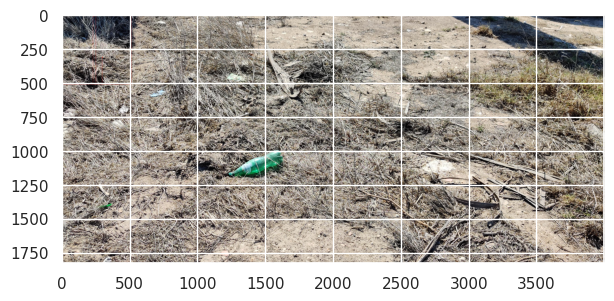

In [ ]:
pred_boxes = torch.tensor(predicted_bboxes[0])[:len(predicted_class_labels[0])].long()
print(pred_boxes)
image = (255.0 * (images[2] - images[2].min()) / (images[2].max() - images[2].min())).to(torch.uint8)
image = image[:3, ...]
output_image = draw_bounding_boxes(image, pred_boxes, ['1','1','1'], colors="red")

plt.figure(figsize=(7, 7))
plt.imshow(output_image.permute(1, 2, 0))

3
512
[[295.11376214027405, 304.1722071170807, 295.1543321609497, 511.0], [0.0, 0.0, 511.0, 511.0], [228.63218399882317, 0.0, 249.25445547699928, 511.0]]


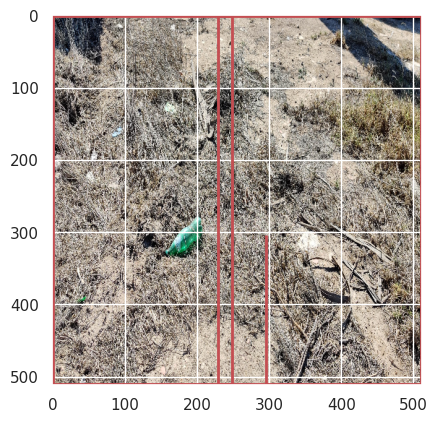

In [ ]:
# Display the image using imshow
image = images[2].unsqueeze(0)
image = F.resize(image, (512, 512))

# Create figure and axes
fig, ax = plt.subplots()

image_data = image.squeeze(0).numpy()
print(len(image_data))
image_data = np.transpose(image_data, (1, 2, 0))
print(len(image_data))
ax.imshow(image_data)

# Create a rectangle patch
print(predicted_bboxes[0])
for i in range(len(predicted_bboxes[0])):
  rectangle = patches.Rectangle((predicted_bboxes[0][i][0], predicted_bboxes[0][i][1]),
                                predicted_bboxes[0][i][2] - predicted_bboxes[0][i][0],
                                predicted_bboxes[0][i][3] - predicted_bboxes[0][i][1],
                                linewidth=2, edgecolor='r', facecolor='none')

  # Add the rectangle patch to the axes
  ax.add_patch(rectangle)

# Show the plot
plt.show()

In [ ]:
def compare_bboxes_for_image(
    image,
    predicted_bboxes,
    #actual_bboxes,
    draw_bboxes_fn=draw_pascal_voc_bboxes,
    figsize=(20, 20),
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(image)
    ax1.set_title("Prediction")
    ax2.imshow(image)
    ax2.set_title("Actual")

    draw_bboxes_fn(ax1, predicted_bboxes)
    #draw_bboxes_fn(ax2, actual_bboxes)

    plt.show()

TypeError: ignored

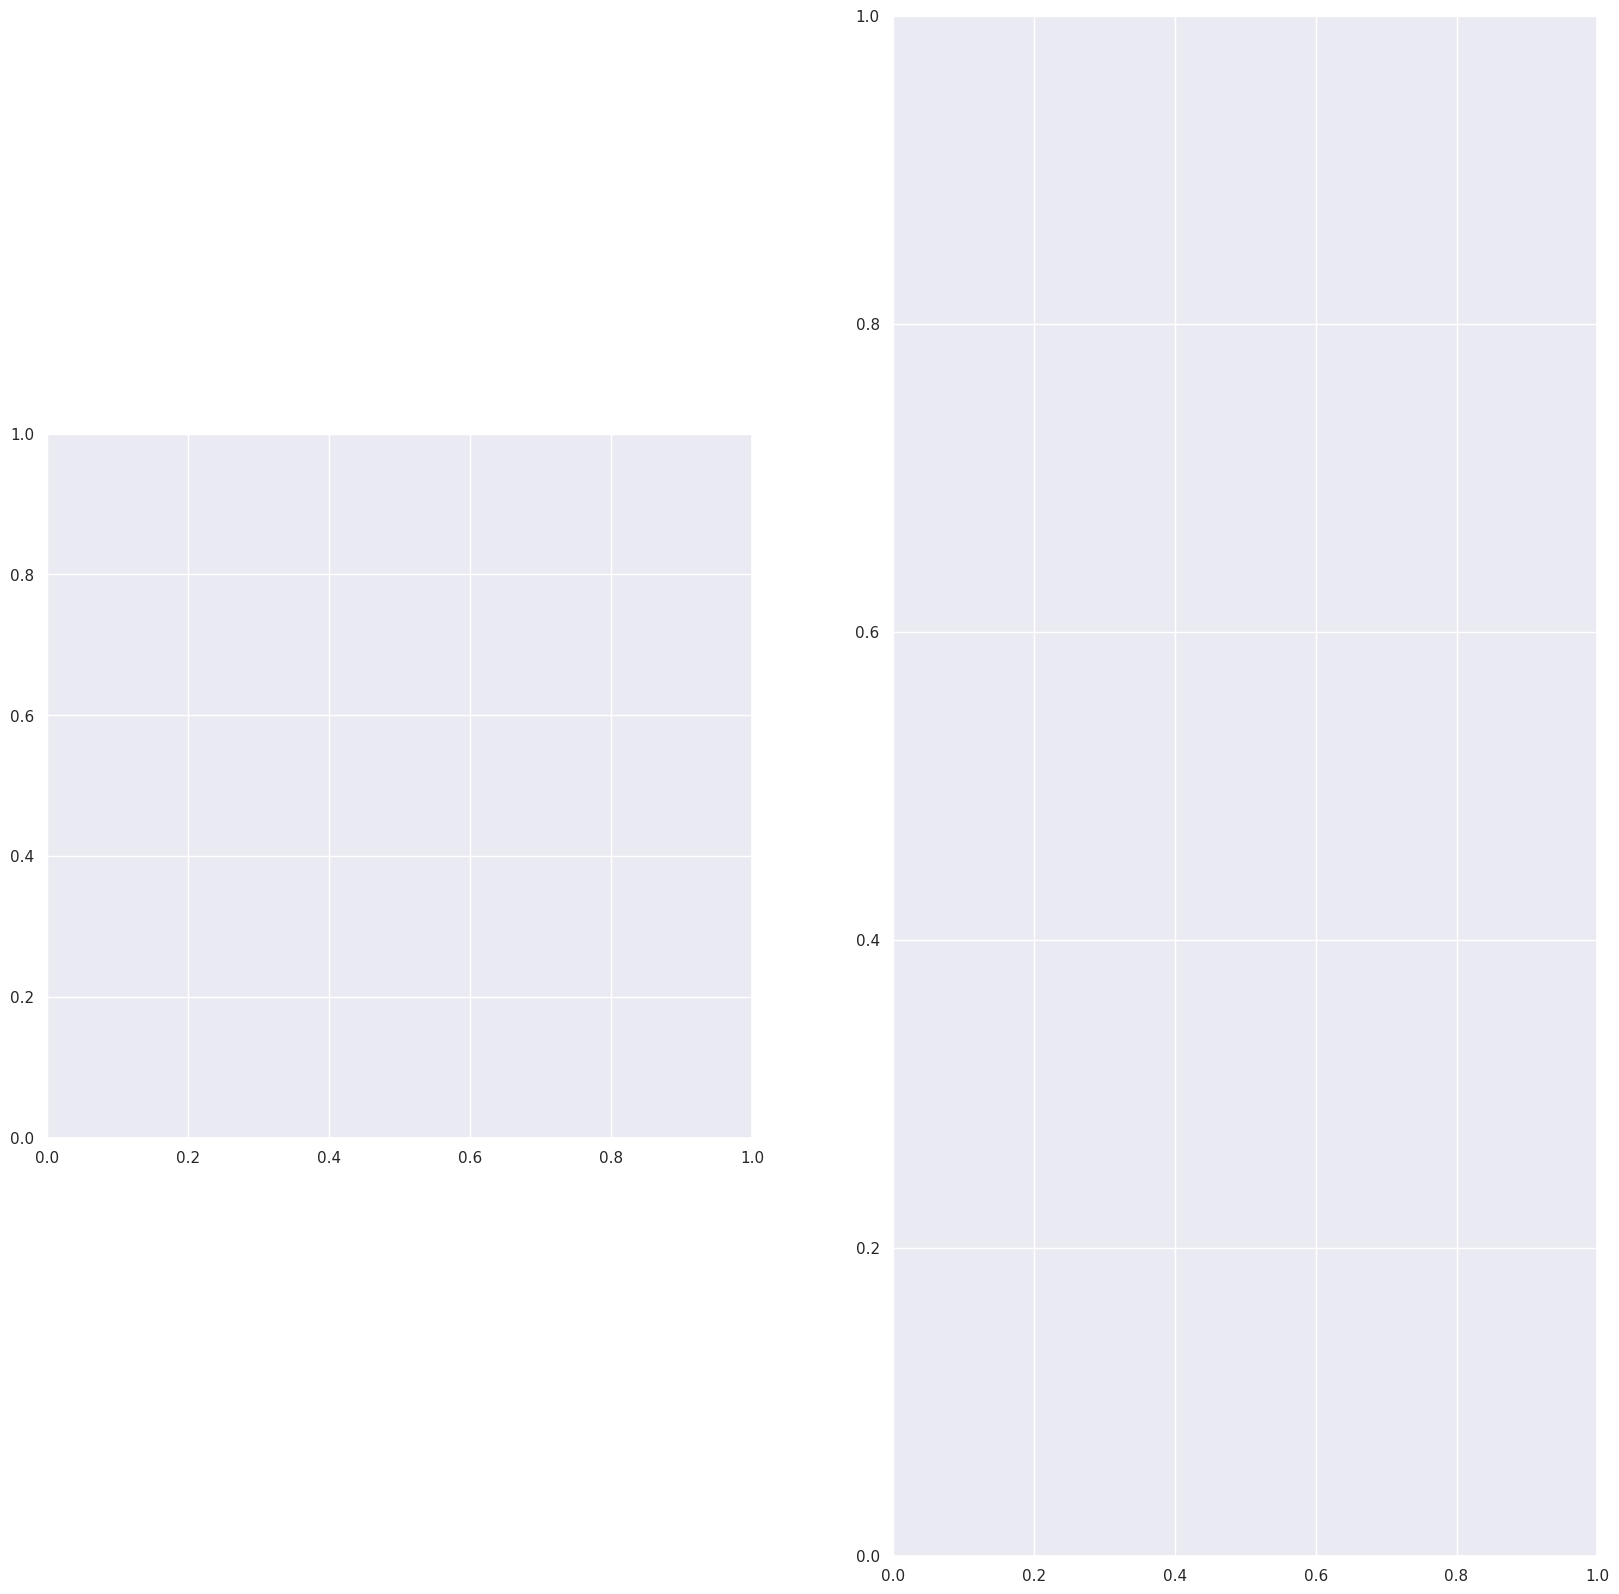

In [ ]:
compare_bboxes_for_image(images[0].numpy(), predicted_bboxes=predicted_bboxes[0])